In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.model_selection import ParameterGrid

In [285]:
pd.options.display.max_columns = None

# Function

In [2]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [3]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

# Strategia

In [ ]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

In [ ]:
def liquidity_out_function(current_liquidity: float, coef_liquidity_out:float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando 
    TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
    Aumentiamo la liquidità in base al modulo della variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [ ]:
def liquidity_in_function(current_liquidity: float, coef_liquidity_in: float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando
    ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
    Riduciamo la liquidità in base alla variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [116]:
def simulate_trading_strategy(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    rebalancing_period: int = 7,
    ma_window: int = 10,
    weighting_factor: float = 0.5,
    coef_liquidity_out: float = 1.0,
    coef_liquidity_in: float = 1.0,
    # Funzioni per aggiornare la liquidità (parametrizzabili)
    func_liquidity_out=liquidity_out_function,
    func_liquidity_in=liquidity_in_function,
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto, secondo la logica descritta,
    con l'uso dell'ultimo massimo locale definito come 'picco'.
    
    Parametri
    ---------
    crypto_prices : pd.DataFrame
        DataFrame che ha come indice i timestamp e come colonne le varie crypto (ad es. 'BTC', 'ETH', 'SOL').
    initial_liquidity : float
        Quantità iniziale di liquidità (es. 10000).
    initial_allocations : dict
        Dizionario che contiene le allocazioni percentuali iniziali 
        (comprese le crypto e la voce 'liquidity').
        Esempio: {'BTC': 0.3, 'ETH': 0.5, 'SOL': 0.1, 'liquidity': 0.1}
        La somma dei valori deve essere 1.
    rebalancing_period : int, default 7
        Ogni quante giornate ribilanciare il portafoglio.
    ma_window : int, default 10
        Finestra di calcolo per la media mobile sulle variazioni di prezzo di ciascuna crypto.
    weighting_factor : float, default 0.5
        Parametro che regola il peso tra:
         - dizionario parziale 1 (M.A. normalizzate)
         - dizionario parziale 2 (100% nella crypto con M.A. più alta).
    func_liquidity_out : function
        Funzione di callback che, dato (current_liquidity, variation_percent_ma),
        restituisce la nuova liquidity desiderata quando TUTTO è in discesa.
    func_liquidity_in : function
        Funzione di callback che, dato (current_liquidity, variation_percent_ma),
        restituisce la nuova liquidity desiderata quando ALMENO UNO è in salita.
    
    Ritorna
    -------
    pd.DataFrame
        DataFrame con tante righe quante sono le date in crypto_prices, e con le colonne:
        - timestamp
        - prezzi di ogni crypto (price_{c})
        - quantità detenute per ogni crypto (qty_{c})
        - controvalore di ogni crypto (value_{c})
        - liquidità posseduta
        - valore totale del portafoglio
        - medie mobili delle crypto (MA_{c})
        - ultimo massimo locale delle medie mobili (LAST_LOCAL_MAX_{c})
        - prezzo medio delle crypto (average_price)
        - variazione percentuale del prezzo medio (avg_price_return)
        - media mobile di questa variazione (MA_avg_price_return)
        - colonna di check: portfolio_value_check
    """
    
    # 1) Preparazione del DataFrame
    prices_df = crypto_prices.copy()
    prices_df.sort_index(inplace=True)
    
    # 2) Calcoliamo la variazione percentuale giornaliera
    daily_returns = prices_df.pct_change().fillna(0)
    
    # 3) Calcoliamo la media mobile sulle variazioni di ciascuna crypto
    ma_columns = {}
    for col in prices_df.columns:
        ma_col_name = f"MA_{col}"
        prices_df[ma_col_name] = daily_returns[col].rolling(window=ma_window).mean().fillna(0)
        ma_columns[col] = ma_col_name
    
    # 4) Per ogni crypto, calcoliamo l'ultimo massimo locale della M.A.
    #    e salviamo in colonna "LAST_LOCAL_MAX_{crypto}"
    for crypto in prices_df.columns:
        if crypto.startswith("MA_"):
            continue  # evitiamo di calcolare per le MA stesse
    # in realtà, vogliamo calcolare la LAST_LOCAL_MAX sulle M.A. vere e proprie, 
    # quindi saltiamo le colonne originali di "prices_df.columns" e usiamo "ma_columns".
    
    for crypto in ma_columns:
        ma_col = ma_columns[crypto]  # Esempio: "MA_BTC"
        last_local_max_col = f"LAST_LOCAL_MAX_{crypto}"
        prices_df[last_local_max_col] = compute_last_local_max(prices_df[ma_col])
    
    # 5) Calcoliamo il prezzo medio delle crypto
    prices_df["average_price"] = prices_df[crypto_prices.columns].mean(axis=1)
    
    # 6) Calcoliamo la variazione percentuale del prezzo medio
    prices_df["avg_price_return"] = prices_df["average_price"].pct_change().fillna(0)
    
    # 7) Calcoliamo la media mobile di questa variazione
    prices_df["MA_avg_price_return"] = prices_df["avg_price_return"].rolling(window=ma_window).mean().fillna(0)
    
    # 8) Inizializzazione del portafoglio
    crypto_list = [k for k in initial_allocations.keys() if k.lower() != "liquidity"]
    
    # Check somma = 1
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError("La somma delle allocazioni iniziali deve essere 1.0")
    
    current_quantities = {c: 0 for c in crypto_list}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0)
    
    # Prezzi del giorno 0
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_list]
    
    for c in crypto_list:
        perc = initial_allocations[c]
        capital_for_c = initial_liquidity * perc
        price_c = first_row[c]
        if price_c != 0:
            current_quantities[c] = capital_for_c / price_c
        else:
            current_quantities[c] = 0
    
    # 9) Funzione per calcolare il valore del portafoglio
    def portfolio_value(prices_row, quantities_dict, liquidity_amount):
        total = liquidity_amount
        for cc in crypto_list:
            total += quantities_dict[cc] * prices_row[cc]
        return total
    
    # 10) Loop sui giorni e costruzione dei record
    records = []
    
    for i, current_date in enumerate(prices_df.index):
        row_prices = prices_df.loc[current_date, crypto_list]
        
        # Calcoliamo il valore attuale
        current_portfolio_value = portfolio_value(row_prices, current_quantities, current_liquidity)
        
        # Salviamo i valori di M.A. correnti
        current_ma_values = {}
        for c in crypto_list:
            ma_col = ma_columns[c]
            current_ma_values[c] = prices_df.loc[current_date, ma_col]
        
        # Prepariamo un record con le info
        record = {
            "timestamp": current_date,
            "liquidity": current_liquidity,
            "portfolio_value": current_portfolio_value,
            "average_price": prices_df.loc[current_date, "average_price"],
            "avg_price_return": prices_df.loc[current_date, "avg_price_return"],
            "MA_avg_price_return": prices_df.loc[current_date, "MA_avg_price_return"],
        }
        
        # Aggiungiamo i prezzi, quantità e controvalori
        for c in crypto_list:
            record[f"price_{c}"] = row_prices[c]
            record[f"qty_{c}"] = current_quantities[c]
            record[f"value_{c}"] = current_quantities[c] * row_prices[c]
            record[f"MA_{c}"] = prices_df.loc[current_date, ma_columns[c]]
            record[f"LAST_LOCAL_MAX_{c}"] = prices_df.loc[current_date, f"LAST_LOCAL_MAX_{c}"]
        
        # Ribilanciamento
        if i > 0 and (i % rebalancing_period == 0):
            # 1) Dizionario parziale basato sulle M.A. (normalizzate)
            #    Se le M.A. fossero negative o zero, potremmo limitarle a 0, 
            #    qui usiamo il valore assoluto per stare generici.
            ma_sum = sum(abs(current_ma_values[c]) for c in crypto_list)
            if np.isclose(ma_sum, 0):
                partial_dict_ma = {c: 1.0 / len(crypto_list) for c in crypto_list}
            else:
                partial_dict_ma = {c: abs(current_ma_values[c]) / ma_sum for c in crypto_list}
            
            # 2) Dizionario parziale 2: 100% nella crypto con M.A. più alta
            max_crypto = max(crypto_list, key=lambda x: current_ma_values[x])
            partial_dict_max = {c: 0.0 for c in crypto_list}
            partial_dict_max[max_crypto] = 1.0
            
            # 3) Dizionario finale = media pesata
            final_dict = {}
            for c in crypto_list:
                final_dict[c] = ((1 - weighting_factor) * partial_dict_ma[c]
                                 + weighting_factor * partial_dict_max[c])
            
            # 4) Controlliamo se tutte le crypto sono in discesa o se almeno una è in salita
            all_down = True
            at_least_one_up = False
            
            variation_percent_ma = prices_df.loc[current_date, "MA_avg_price_return"]
            
            for c in crypto_list:
                current_ma = prices_df.loc[current_date, ma_columns[c]]
                last_local_max_val = prices_df.loc[current_date, f"LAST_LOCAL_MAX_{c}"]
                
                # Se NON esiste un ultimo max locale, decidiamo come gestire:
                if pd.isna(last_local_max_val):
                    # Convenzione: se non c'è ancora un max locale, non la consideriamo in discesa
                    all_down = False
                else:
                    # Se l'attuale MA è >= dell'ultimo max locale, la crypto non è in discesa
                    if current_ma >= last_local_max_val:
                        all_down = False
                        at_least_one_up = True
            
            desired_liquidity_pct = current_liquidity / current_portfolio_value
            
            if all_down:
                # Se tutte in discesa, aumento la liquidità
                new_liq_pct = func_liquidity_out(desired_liquidity_pct, coef_liquidity_out, variation_percent_ma)
            elif at_least_one_up:
                # Se almeno una in salita, riduco la liquidità
                new_liq_pct = func_liquidity_in(desired_liquidity_pct, coef_liquidity_in, variation_percent_ma)
            else:
                # Caso neutro (es. se M.A. rimangono costanti, ecc.)
                new_liq_pct = desired_liquidity_pct
            
            # 5) Ribilanciamento vero e proprio
            value_for_crypto = current_portfolio_value * (1 - new_liq_pct)
            
            # 5a) Vendita totale
            total_sell = 0.0
            for c in crypto_list:
                total_sell += current_quantities[c] * row_prices[c]
                current_quantities[c] = 0.0
            current_liquidity += total_sell
            
            # 5b) Ricompriamo secondo final_dict
            for c in crypto_list:
                desired_pct_c = final_dict[c]
                capital_for_c = value_for_crypto * desired_pct_c
                price_c = row_prices[c]
                if price_c != 0:
                    qty_to_buy = capital_for_c / price_c
                else:
                    qty_to_buy = 0
                
                current_liquidity -= capital_for_c
                current_quantities[c] = qty_to_buy
            
            # 5c) Se la liquidità effettiva < quella desiderata, vendiamo un po' di crypto
            current_total_value = portfolio_value(row_prices, current_quantities, current_liquidity)
            desired_liquidity_amount = current_total_value * new_liq_pct
            
            if current_liquidity < desired_liquidity_amount:
                needed = desired_liquidity_amount - current_liquidity
                # vendiamo in proporzione alle allocazioni final_dict
                for c in crypto_list:
                    c_value = current_quantities[c] * row_prices[c]
                    # Evitiamo divisione per zero
                    denom = (current_total_value - current_liquidity) if (current_total_value - current_liquidity) != 0 else 1e-9
                    c_share = c_value / denom
                    to_sell = needed * c_share
                    if row_prices[c] != 0:
                        qty_to_sell = to_sell / row_prices[c]
                        if qty_to_sell > current_quantities[c]:
                            qty_to_sell = current_quantities[c]
                        current_quantities[c] -= qty_to_sell
                        current_liquidity += to_sell
                current_total_value = portfolio_value(row_prices, current_quantities, current_liquidity)
        
        # Aggiungiamo il record (PRIMA del ribilanciamento di oggi, o DOPO se vuoi spostarlo)
        records.append(record)
    
    # Costruiamo il DataFrame finale
    result_df = pd.DataFrame(records)
    
    # Colonna di check
    crypto_val_cols = [col for col in result_df.columns if col.startswith("value_")]
    result_df["portfolio_value_check"] = result_df[crypto_val_cols].sum(axis=1) + result_df["liquidity"]
    
    return result_df

In [94]:
initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
# initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

In [95]:
cryptos = list(initial_allocations.keys())  # Specifica le crypto

In [159]:
timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2021-01-01'  # Data di inizio
end_date = '2021-12-31'  # Data di fine
plot = False
market = 'binance'

data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

Scarico i dati per BTC/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per ETH/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per SOL/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per DOGE/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per LINK/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per AXS/USDT dal 2021-01-01 al 2021-12-31...


In [160]:
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[cryptos[0]].index
for crypto in cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values
crypto_prices.set_index('timestamp', inplace=True)

# Calcolo del prezzo medio
crypto_prices['mean_price'] = crypto_prices.mean(axis=1)

crypto_prices

,BTC,ETH,SOL,DOGE,LINK,AXS,mean_price
timestamp,,,,,,,
2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679,11.2812,0.53441,4957.094081
2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737,11.4735,0.53366,5028.642549
2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755,11.5773,0.53321,4992.068744
2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978,11.5006,0.54173,5006.145035
2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894,11.4575,0.53912,4996.033952
...,...,...,...,...,...,...,...
2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100,19.8700,95.08000,8536.041850
2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800,19.9900,95.53000,8554.303633
2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000,19.8600,94.73000,8512.525167


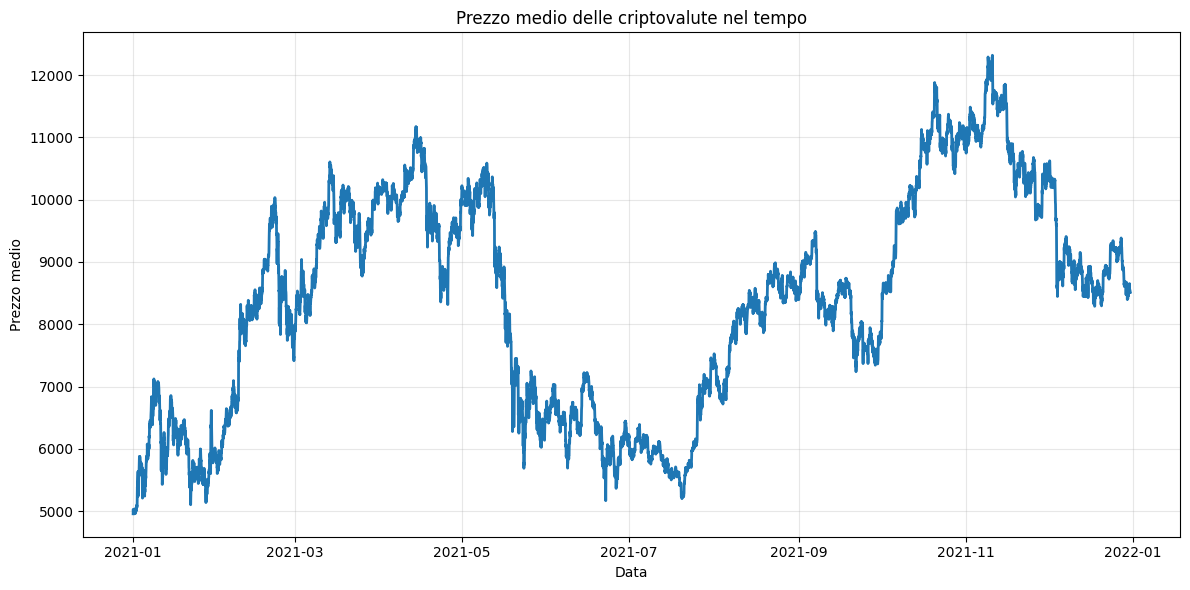

In [161]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices['mean_price'], label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [162]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [163]:
# crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
# crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
# crypto_prices.set_index('timestamp', inplace=True)
# crypto_prices

In [164]:
crypto_prices.isna().sum().sum()

0

In [286]:
# Parametri fissi
initial_liquidity = 100

# Parametri variabili
rebalancing_period = 6
ma_window = 12
weighting_factor = 1
perc_liquidity_out = 1
perc_liquidity_in = 3

df_results = simulate_trading_strategy(crypto_prices, initial_liquidity, initial_allocations, rebalancing_period, ma_window, weighting_factor, perc_liquidity_out, perc_liquidity_in)
df_results

,timestamp,liquidity,portfolio_value,average_price,avg_price_return,MA_avg_price_return,price_BTC,qty_BTC,value_BTC,MA_BTC,LAST_LOCAL_MAX_BTC,price_ETH,qty_ETH,value_ETH,MA_ETH,LAST_LOCAL_MAX_ETH,price_SOL,qty_SOL,value_SOL,MA_SOL,LAST_LOCAL_MAX_SOL,price_DOGE,qty_DOGE,value_DOGE,MA_DOGE,LAST_LOCAL_MAX_DOGE,price_LINK,qty_LINK,value_LINK,MA_LINK,LAST_LOCAL_MAX_LINK,price_AXS,qty_AXS,value_AXS,MA_AXS,LAST_LOCAL_MAX_AXS,portfolio_value_check
0,2021-01-01 00:00:00,0.000000,1.000000e+02,4957.094081,0.000000,0.000000,28995.13,0.000575,1.666667e+01,0.000000,NaN,734.07,0.022704,16.666667,0.000000,NaN,1.5442,10.793075,16.666667,0.000000,NaN,0.004679,3562.166937,16.666667,0.000000,NaN,11.2812,1.477384,16.666667,0.000000,NaN,0.53441,31.187041,16.666667,0.000000,NaN,1.000000e+02
1,2021-01-01 01:00:00,0.000000,1.013425e+02,5028.642549,0.014434,0.000000,29409.99,0.000575,1.690513e+01,0.000000,0.000000,748.28,0.022704,16.989297,0.000000,0.000000,1.5734,10.793075,16.981824,0.000000,0.000000,0.004737,3562.166937,16.872204,0.000000,0.000000,11.4735,1.477384,16.950768,0.000000,0.000000,0.53366,31.187041,16.643276,0.000000,0.000000,1.013425e+02
2,2021-01-01 02:00:00,0.000000,1.014774e+02,4992.068744,-0.007273,0.000000,29194.65,0.000575,1.678135e+01,0.000000,0.000000,744.06,0.022704,16.893484,0.000000,0.000000,1.5872,10.793075,17.130769,0.000000,0.000000,0.004755,3562.166937,16.938460,0.000000,0.000000,11.5773,1.477384,17.104120,0.000000,0.000000,0.53321,31.187041,16.629242,0.000000,0.000000,1.014774e+02
3,2021-01-01 03:00:00,0.000000,1.026590e+02,5006.145035,0.002820,0.000000,29278.40,0.000575,1.682949e+01,0.000000,0.000000,744.82,0.022704,16.910740,0.000000,0.000000,1.6029,10.793075,17.300220,0.000000,0.000000,0.004978,3562.166937,17.732823,0.000000,0.000000,11.5006,1.477384,16.990805,0.000000,0.000000,0.54173,31.187041,16.894956,0.000000,0.000000,1.026590e+02
4,2021-01-01 04:00:00,0.000000,1.021153e+02,4996.033952,-0.002020,0.000000,29220.31,0.000575,1.679610e+01,0.000000,0.000000,742.29,0.022704,16.853297,0.000000,0.000000,1.6022,10.793075,17.292665,0.000000,0.000000,0.004894,3562.166937,17.432533,0.000000,0.000000,11.4575,1.477384,16.927130,0.000000,0.000000,0.53912,31.187041,16.813558,0.000000,0.000000,1.021153e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2021-12-30 20:00:00,285944.241966,1.453851e+06,8536.041850,-0.007428,0.000738,47203.16,24.742140,1.167907e+06,0.000739,0.001709,3724.78,0.000000,0.000000,0.000759,0.002113,173.1900,0.000000,0.000000,0.000334,0.002242,0.171100,0.000000,0.000000,-0.000077,0.001774,19.8700,0.000000,0.000000,0.000836,0.003357,95.08000,0.000000,0.000000,0.000344,0.002184,1.453851e+06
8720,2021-12-30 21:00:00,285944.241966,1.456247e+06,8554.303633,0.002139,0.000998,47300.00,24.742140,1.170303e+06,0.000985,0.000985,3736.93,0.000000,0.000000,0.001194,0.001194,173.2000,0.000000,0.000000,0.000464,0.000464,0.171800,0.000000,0.000000,0.000166,0.000166,19.9900,0.000000,0.000000,0.001128,0.001128,95.53000,0.000000,0.000000,0.000791,0.000791,1.456247e+06
8721,2021-12-30 22:00:00,285944.241966,1.450925e+06,8512.525167,-0.004884,0.000237,47084.88,24.742140,1.164981e+06,0.000250,0.000985,3703.83,0.000000,0.000000,0.000123,0.001194,171.6800,0.000000,0.000000,-0.000640,0.000464,0.171000,0.000000,0.000000,-0.000951,0.000166,19.8600,0.000000,0.000000,0.000248,0.001128,94.73000,0.000000,0.000000,-0.000250,0.000791,1.450925e+06
8722,2021-12-30 23:00:00,285944.241966,1.451815e+06,8519.626850,0.000834,-0.000681,47120.87,24.742140,1.165871e+06,-0.000684,0.000985,3709.27,0.000000,0.000000,-0.000620,0.001194,172.5200,0.000000,0.000000,-0.001036,0.000464,0.171100,0.000000,0.000000,-0.001865,0.000166,19.9300,0.000000,0.000000,-0.000973,0.001128,95.00000,0.000000,0.000000,-0.000705,0.000791,1.451815e+06


In [287]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

14506.552680822573

In [288]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

36576.33425527844

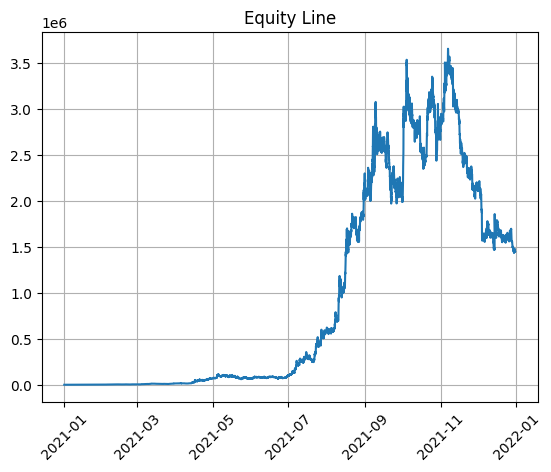

In [289]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [290]:
mdp.calcola_principali_metriche(prices=df_results['average_price'], bitcoin_posseduti=df_results['liquidity'], portfolio_values=df_results['portfolio_value'])

{'Total Return %': 1450555.2680822574,
 'Max Drawdown': 60.704485957713835,
 'Volatility': 0.3973826310448719,
 'Sharpe Ratio': 0.8856135031857029,
 'Sortino Ratio': 1.7401271315425446,
 'Calmar Ratio': 23895.355428801427,
 'Profit Factor': 1.4139967300921805,
 'PnL': 225581.31208807818}

In [291]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys()], initial_liquidity, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[7.476989653311245e+59, 3.78118401229478e+63]

# Grid search

In [292]:
# Parametri fissi
initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_liquidity = 100
sort_quantity = 'fattore_rendimento_totale'

In [293]:
def grid_search_rebalancing(dati, grid_params, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        print(f"Inizio iterazione {idx + 1}/{len(grid_params)}")
        print(f"Parametri: {params}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy(
                dati,
                initial_liquidity,
                initial_allocations,
                params['rebalancing_period'],
                params['ma_window'],
                params['weighting_factor'],
                params['perc_liquidity_out'],
                params['perc_liquidity_in']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    print("Grid search completata. Migliori risultati:")

    return risultati_df

In [294]:
# Dizionario dei parametri per la grid search
param_grid = {
    'rebalancing_period': [6, 24, 24*3, 24*7],
    'ma_window': [12, 24, 48, 72],
    'weighting_factor': [0, 0.5, 1],
    'perc_liquidity_out': [1, 5, np.inf],
    'perc_liquidity_in': [1, 5, np.inf],
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = []

for comb in grid_params:
    condition = False
    
    skip_conditions.append(condition)

crypto_list = crypto_prices.columns

risultati_df_ordinati = grid_search_rebalancing(crypto_prices, grid_params, initial_liquidity, skip_conditions, sort_quantity)
risultati_df_ordinati

Inizio iterazione 1/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': 1, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0}
Iterazione 1 completata: Fattore Rendimento Totale = 421.5762900361906
Inizio iterazione 2/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': 1, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0.5}
Iterazione 2 completata: Fattore Rendimento Totale = 2828.583607823563
Inizio iterazione 3/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': 1, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 1}
Iterazione 3 completata: Fattore Rendimento Totale = 12745.204358428618
Inizio iterazione 4/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': 1, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 4 completata: Fattore Rendimento Totale = 79.16894348816777
Inizio iterazione 5/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': 1, 'perc_liquidity_out': 1, 'rebalanci

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 73 completata: Fattore Rendimento Totale = nan
Inizio iterazione 74/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 74 completata: Fattore Rendimento Totale = nan
Inizio iterazione 75/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 75 completata: Fattore Rendimento Totale = nan
Inizio iterazione 76/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 76 completata: Fattore Rendimento Totale = 5.955511781864349
Inizio iterazione 77/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 77 completata: Fattore Rendimento Totale = 13.257663369173738
Inizio iterazione 78/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 78 completata: Fattore Rendimento Totale = 24.3619085932384
Inizio iterazione 79/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 79 completata: Fattore Rendimento Totale = 13.395189785356955
Inizio iterazione 80/432
Parametri:

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 85 completata: Fattore Rendimento Totale = nan
Inizio iterazione 86/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 86 completata: Fattore Rendimento Totale = nan
Inizio iterazione 87/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 87 completata: Fattore Rendimento Totale = nan
Inizio iterazione 88/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 88 completata: Fattore Rendimento Totale = 5.955845314373526
Inizio iterazione 89/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 89 completata: Fattore Rendimento Totale = 13.184053825396779
Inizio iterazione 90/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 90 completata: Fattore Rendimento Totale = 24.158206671278787
Inizio iterazione 91/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 91 completata: Fattore Rendimento Totale = 13.344190166545708
Inizio iterazione 92/432
Parametr

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 97 completata: Fattore Rendimento Totale = nan
Inizio iterazione 98/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 98 completata: Fattore Rendimento Totale = nan
Inizio iterazione 99/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 99 completata: Fattore Rendimento Totale = nan
Inizio iterazione 100/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 100 completata: Fattore Rendimento Totale = 2.896526269861754
Inizio iterazione 101/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 101 completata: Fattore Rendimento Totale = 5.728836068973124
Inizio iterazione 102/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 102 completata: Fattore Rendimento Totale = 10.031131937571361
Inizio iterazione 103/432
Parametri: {'ma_window': 12, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 103 completata: Fattore Rendimento Totale = 8.775384174167561
Inizio iterazione 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 181 completata: Fattore Rendimento Totale = nan
Inizio iterazione 182/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 182 completata: Fattore Rendimento Totale = nan
Inizio iterazione 183/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 183 completata: Fattore Rendimento Totale = nan
Inizio iterazione 184/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 184 completata: Fattore Rendimento Totale = 6.295463363685926
Inizio iterazione 185/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 185 completata: Fattore Rendimento Totale = 10.979947283857086
Inizio iterazione 186/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 186 completata: Fattore Rendimento Totale = 15.921820432670732
Inizio iterazione 187/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 187 completata: Fattore Rendimento Totale = 25.358311820560886
Inizio iterazione 188/43

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 193 completata: Fattore Rendimento Totale = nan
Inizio iterazione 194/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 194 completata: Fattore Rendimento Totale = nan
Inizio iterazione 195/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 195 completata: Fattore Rendimento Totale = nan
Inizio iterazione 196/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 196 completata: Fattore Rendimento Totale = 6.293273243702733
Inizio iterazione 197/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 197 completata: Fattore Rendimento Totale = 10.95492144432705
Inizio iterazione 198/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 198 completata: Fattore Rendimento Totale = 15.863409349584193
Inizio iterazione 199/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 199 completata: Fattore Rendimento Totale = 24.95219782188135
Inizio iterazione 200/432


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 205 completata: Fattore Rendimento Totale = nan
Inizio iterazione 206/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 206 completata: Fattore Rendimento Totale = nan
Inizio iterazione 207/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 207 completata: Fattore Rendimento Totale = nan
Inizio iterazione 208/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0}
Iterazione 208 completata: Fattore Rendimento Totale = 3.7121453026099025
Inizio iterazione 209/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0.5}
Iterazione 209 completata: Fattore Rendimento Totale = 4.641176273090382
Inizio iterazione 210/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 1}
Iterazione 210 completata: Fattore Rendimento Totale = 5.049104868218001
Inizio iterazione 211/432
Parametri: {'ma_window': 24, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 211 completata: Fattore Rendimento Totale = 6.621663153019696
Inizio iterazione 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 289 completata: Fattore Rendimento Totale = nan
Inizio iterazione 290/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 290 completata: Fattore Rendimento Totale = nan
Inizio iterazione 291/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 291 completata: Fattore Rendimento Totale = nan
Inizio iterazione 292/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 292 completata: Fattore Rendimento Totale = nan
Inizio iterazione 293/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 293 completata: Fattore Rendimento Totale = nan
Inizio iterazione 294/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 294 completata: Fattore Rendimento Totale = nan
Inizio iterazione 295/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 295 completata: Fattore Rendimento Totale = 35.03136669536234
Inizio iterazione 296/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 296 completata: Fattore Rendimento Totale = 100.8256354771641
Inizio iterazione 297/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 297 completata: Fattore Rendimento Totale = 220.9055776816999
Inizio iterazione 298/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 298 completata: Fattore Rendimento Totale = 39.40602207150555
Inizio iterazione 299/432


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 301 completata: Fattore Rendimento Totale = nan
Inizio iterazione 302/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 302 completata: Fattore Rendimento Totale = nan
Inizio iterazione 303/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 303 completata: Fattore Rendimento Totale = nan
Inizio iterazione 304/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 304 completata: Fattore Rendimento Totale = nan
Inizio iterazione 305/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 305 completata: Fattore Rendimento Totale = nan
Inizio iterazione 306/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 306 completata: Fattore Rendimento Totale = nan
Inizio iterazione 307/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 307 completata: Fattore Rendimento Totale = 34.92662321888686
Inizio iterazione 308/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 308 completata: Fattore Rendimento Totale = 100.59378771279285
Inizio iterazione 309/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 309 completata: Fattore Rendimento Totale = 220.65833005041756
Inizio iterazione 310/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 310 completata: Fattore Rendimento Totale = 38.889191880093804
Inizio iterazione 311/4

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 313 completata: Fattore Rendimento Totale = nan
Inizio iterazione 314/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 314 completata: Fattore Rendimento Totale = nan
Inizio iterazione 315/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 315 completata: Fattore Rendimento Totale = nan
Inizio iterazione 316/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 316 completata: Fattore Rendimento Totale = nan
Inizio iterazione 317/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 317 completata: Fattore Rendimento Totale = nan
Inizio iterazione 318/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 318 completata: Fattore Rendimento Totale = nan
Inizio iterazione 319/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 319 completata: Fattore Rendimento Totale = 26.689694422398663
Inizio iterazione 320/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 320 completata: Fattore Rendimento Totale = 83.30919666512504
Inizio iterazione 321/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 321 completata: Fattore Rendimento Totale = 204.24766357872284
Inizio iterazione 322/432
Parametri: {'ma_window': 48, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 322 completata: Fattore Rendimento Totale = 8.645926396517828
Inizio iterazion

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 397 completata: Fattore Rendimento Totale = nan
Inizio iterazione 398/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 398 completata: Fattore Rendimento Totale = nan
Inizio iterazione 399/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 399 completata: Fattore Rendimento Totale = nan
Inizio iterazione 400/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 400 completata: Fattore Rendimento Totale = nan
Inizio iterazione 401/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 401 completata: Fattore Rendimento Totale = nan
Inizio iterazione 402/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 402 completata: Fattore Rendimento Totale = nan
Inizio iterazione 403/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 403 completata: Fattore Rendimento Totale = 42.449757885382965
Inizio iterazione 404/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 404 completata: Fattore Rendimento Totale = 59.0284957222727
Inizio iterazione 405/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 405 completata: Fattore Rendimento Totale = 67.05285913638315
Inizio iterazione 406/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 1, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 406 completata: Fattore Rendimento Totale = 7.66136270396826
Inizio iterazione 407/432
P

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 409 completata: Fattore Rendimento Totale = nan
Inizio iterazione 410/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 410 completata: Fattore Rendimento Totale = nan
Inizio iterazione 411/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 411 completata: Fattore Rendimento Totale = nan
Inizio iterazione 412/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 412 completata: Fattore Rendimento Totale = nan
Inizio iterazione 413/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 413 completata: Fattore Rendimento Totale = nan
Inizio iterazione 414/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 414 completata: Fattore Rendimento Totale = nan
Inizio iterazione 415/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 415 completata: Fattore Rendimento Totale = 42.236468264908886
Inizio iterazione 416/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 416 completata: Fattore Rendimento Totale = 58.84625821144625
Inizio iterazione 417/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 417 completata: Fattore Rendimento Totale = 67.0284210682835
Inizio iterazione 418/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': 5, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 418 completata: Fattore Rendimento Totale = 7.628696803347645
Inizio iterazione 419/432


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 421 completata: Fattore Rendimento Totale = nan
Inizio iterazione 422/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 422 completata: Fattore Rendimento Totale = nan
Inizio iterazione 423/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 6, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidit

Iterazione 423 completata: Fattore Rendimento Totale = nan
Inizio iterazione 424/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 424 completata: Fattore Rendimento Totale = nan
Inizio iterazione 425/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 0.5}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 425 completata: Fattore Rendimento Totale = nan
Inizio iterazione 426/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 24, 'weighting_factor': 1}


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_30060\3194786008.py:68: RuntimeWarning: invalid value encountered in scalar multiply
  new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma


Iterazione 426 completata: Fattore Rendimento Totale = nan
Inizio iterazione 427/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0}
Iterazione 427 completata: Fattore Rendimento Totale = 29.950276574623864
Inizio iterazione 428/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 0.5}
Iterazione 428 completata: Fattore Rendimento Totale = 45.18165263993505
Inizio iterazione 429/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 72, 'weighting_factor': 1}
Iterazione 429 completata: Fattore Rendimento Totale = 58.85209942364769
Inizio iterazione 430/432
Parametri: {'ma_window': 72, 'perc_liquidity_in': inf, 'perc_liquidity_out': inf, 'rebalancing_period': 168, 'weighting_factor': 0}
Iterazione 430 completata: Fattore Rendimento Totale = 2.6840844398161736
Inizio iterazion

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,12,5.0,1.0,6,1.0,14522.944858,0.395191,60.378019,0.888480,1.747955,24051.708187
1,12,1.0,1.0,6,1.0,12745.204358,0.395751,60.274722,0.878364,1.721156,21143.530807
2,12,5.0,1.0,6,0.5,3261.085681,0.335170,53.282539,0.856970,1.630423,6118.487841
3,12,1.0,1.0,6,0.5,2828.583608,0.335017,53.069506,0.845103,1.598371,5328.075960
4,72,1.0,1.0,6,1.0,1796.349469,0.410647,73.934311,0.723689,1.362928,2428.303505
...,...,...,...,...,...,...,...,...,...,...,...
427,72,inf,inf,6,0.5,NaN,0.113882,0.880642,6.482222,665.445407,NaN
428,72,inf,inf,6,1.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
429,72,inf,inf,24,0.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
430,72,inf,inf,24,0.5,NaN,0.116734,2.019362,7.315620,307.099305,NaN


In [302]:
risultati_df_ordinati[(risultati_df_ordinati['weighting_factor'] == 1) & (risultati_df_ordinati['perc_liquidity_in'] == 5) & (risultati_df_ordinati['perc_liquidity_out'] == 1)].sort_values(by='fattore_rendimento_totale', ascending=False)

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,12,5.0,1.0,6,1.0,14522.944858,0.395191,60.378019,0.888480,1.747955,24051.708187
5,72,5.0,1.0,6,1.0,1477.044564,0.399085,72.356871,0.719124,1.354263,2039.950804
8,48,5.0,1.0,72,1.0,1166.175638,0.340486,60.648759,0.767591,1.378371,1921.186281
16,48,5.0,1.0,6,1.0,646.881901,0.400118,73.721602,0.658857,1.228312,876.109419
22,24,5.0,1.0,6,1.0,538.390373,0.399662,66.948334,0.643155,1.235307,802.694167
34,12,5.0,1.0,24,1.0,284.150998,0.379787,65.247709,0.612164,1.115211,433.963126
46,12,5.0,1.0,72,1.0,212.339448,0.314237,60.616905,0.647924,1.159073,348.647703
57,72,5.0,1.0,24,1.0,195.203871,0.394937,72.380488,0.576352,1.041932,268.309701
77,48,5.0,1.0,24,1.0,134.959955,0.390861,70.186091,0.550936,0.996553,190.863963
96,12,5.0,1.0,168,1.0,101.920280,0.389436,75.579226,0.526812,0.987441,133.529126


In [295]:
risultati_df_ordinati[:50]

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,12,5.0,1.0,6,1.0,14522.944858,0.395191,60.378019,0.888480,1.747955,24051.708187
1,12,1.0,1.0,6,1.0,12745.204358,0.395751,60.274722,0.878364,1.721156,21143.530807
2,12,5.0,1.0,6,0.5,3261.085681,0.335170,53.282539,0.856970,1.630423,6118.487841
3,12,1.0,1.0,6,0.5,2828.583608,0.335017,53.069506,0.845103,1.598371,5328.075960
4,72,1.0,1.0,6,1.0,1796.349469,0.410647,73.934311,0.723689,1.362928,2428.303505
5,72,5.0,1.0,6,1.0,1477.044564,0.399085,72.356871,0.719124,1.354263,2039.950804
6,12,5.0,5.0,6,1.0,1429.360535,0.330205,53.920770,0.791793,1.524966,2648.998751
7,48,1.0,1.0,72,1.0,1191.546111,0.341735,60.610201,0.767830,1.378969,1964.266882
8,48,5.0,1.0,72,1.0,1166.175638,0.340486,60.648759,0.767591,1.378371,1921.186281
9,48,1.0,5.0,72,1.0,1132.142041,0.337692,59.164722,0.768639,1.379620,1911.852203


In [296]:
risultati_df_ordinati['fattore_rendimento_totale'].mean(), risultati_df_ordinati['fattore_rendimento_totale'].median(), risultati_df_ordinati['fattore_rendimento_totale'].min(), risultati_df_ordinati['fattore_rendimento_totale'].max(), risultati_df_ordinati['fattore_rendimento_totale'].std()

(195.3238984695131,
 41.0786583507456,
 1.180839306969574,
 14522.944857713546,
 1030.654322263385)

In [297]:
risultati_df_ordinati.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,72,inf,inf,24,1.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
1,72,inf,1.0,24,1.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
2,48,inf,1.0,24,0.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
3,48,inf,1.0,24,0.5,NaN,0.116734,2.019362,7.315620,307.099305,NaN
4,48,inf,1.0,24,1.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
...,...,...,...,...,...,...,...,...,...,...,...
427,48,1.0,inf,6,0.5,1.309395,0.057723,28.589758,0.163698,0.244214,1.082189
428,48,1.0,inf,24,1.0,1.305778,0.072047,35.273967,0.142835,0.211582,0.866865
429,72,1.0,inf,6,1.0,1.223071,0.049928,23.280903,0.141490,0.203064,0.958173
430,48,5.0,inf,6,1.0,1.200375,0.069384,35.273967,0.110531,0.165139,0.568054


In [298]:
risultati_df_ordinati.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,12,inf,1.0,6,0.5,NaN,0.113882,0.880642,6.482222,665.445407,NaN
1,48,inf,1.0,6,0.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
2,24,inf,1.0,6,1.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
3,24,inf,5.0,6,0.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
4,48,inf,inf,6,1.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
...,...,...,...,...,...,...,...,...,...,...,...
427,48,5.0,inf,24,1.0,1.376507,0.072259,35.273967,0.163718,0.242798,1.067380
428,48,1.0,inf,24,1.0,1.305778,0.072047,35.273967,0.142835,0.211582,0.866865
429,72,1.0,inf,6,1.0,1.223071,0.049928,23.280903,0.141490,0.203064,0.958173
430,48,5.0,inf,6,1.0,1.200375,0.069384,35.273967,0.110531,0.165139,0.568054


In [299]:
risultati_df_ordinati.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,12,5.0,1.0,6,1.0,14522.944858,0.395191,60.378019,0.888480,1.747955,24051.708187
1,12,1.0,1.0,6,1.0,12745.204358,0.395751,60.274722,0.878364,1.721156,21143.530807
2,12,5.0,1.0,6,0.5,3261.085681,0.335170,53.282539,0.856970,1.630423,6118.487841
3,12,1.0,1.0,6,0.5,2828.583608,0.335017,53.069506,0.845103,1.598371,5328.075960
4,12,5.0,5.0,6,1.0,1429.360535,0.330205,53.920770,0.791793,1.524966,2648.998751
...,...,...,...,...,...,...,...,...,...,...,...
427,72,inf,inf,6,0.5,NaN,0.113882,0.880642,6.482222,665.445407,NaN
428,72,inf,inf,6,1.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
429,72,inf,inf,24,0.0,NaN,0.116734,2.019362,7.315620,307.099305,NaN
430,72,inf,inf,24,0.5,NaN,0.116734,2.019362,7.315620,307.099305,NaN


In [300]:
risultati_df_ordinati.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

,ma_window,perc_liquidity_in,perc_liquidity_out,rebalancing_period,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,48,inf,5.0,6,0.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
1,24,inf,5.0,6,0.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
2,24,inf,5.0,6,0.5,NaN,0.113882,0.880642,6.482222,665.445407,NaN
3,24,inf,5.0,6,1.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
4,24,inf,inf,6,0.0,NaN,0.113882,0.880642,6.482222,665.445407,NaN
...,...,...,...,...,...,...,...,...,...,...,...
427,72,5.0,5.0,168,1.0,39.186737,0.389852,77.171995,0.460019,0.817542,49.482636
428,72,5.0,1.0,72,1.0,47.523012,0.342734,77.646423,0.495085,0.867775,59.916491
429,72,5.0,1.0,168,1.0,40.153117,0.393651,77.817501,0.460971,0.819717,50.314025
430,72,1.0,1.0,168,1.0,40.289307,0.393767,77.821368,0.461226,0.820146,50.486527
